![logo](../../picture/license_header_logo.png)
> **Copyright &copy; 2020 - 2021 CertifAI Sdn. Bhd.**<br>
 <br>
This program and the accompanying materials are made available under the
terms of the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). <br>
Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS, WITHOUT
WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the
License for the specific language governing permissions and limitations
under the License. <br>
<br>**SPDX-License-Identifier: Apache-2.0**

# 03 - Recap Exercise 

## Requirement
You should complete all the exercises from Day 1 to Day 3 before proceeding with this recap exercise to optimize your learning experience. 


## Introduction 
This tutorial is to demonstrate the process flow of building time series forecast algorithms from scratch.<br>

>**Example of time series forecasting flow diagram:**
![image](https://user-images.githubusercontent.com/59526258/117595686-0f8aa800-b174-11eb-8996-b08559378fad.png)

This exercise will use five different types of time series forecast model to solve the problem:

1. Naive Forecast
2. Exponential Smoothing Average
3. ARIMA 
4. SARIMA
5. Multilayer perceptron (MLP)

## Problem Statement
You are given a set of the dataset that measures pounds per cow as its unit per month from January 1962 to December 1975. You are required to build a time series forecast algorithm from scratch. Your algorithm must include:
1. Basic analytics of the data.
2. Time series modeling with statistical method.
3. Time series modeling with deep learning method.
4. Compare and choose the best model base on the performance.

## What will we accomplish?
By the end of this tutorial, you will be able to:|
1. Understand the time series forecasting flow.
2. Compare and select the optimal model as forecasting model base on the model performance. 


## Notebook Outline
Below is the outline for this tutorial
1. [Basic Analytics](#BasicAnalytics)
    * [Data Preparation](#DataPreparation)
    * [Data Visualization](#DataVisualization)
    * [Data Splitting](#DataSplitting)
    * [ACF Plot](#ACFPlot)
    * [Time Series Decomposition](#TimeSeriesDecomposition)
    
2. [Time Series Modeling with Statistical Method](#TimeSeriesModelingwithStatisticalMethod)
    * [Naive Forecast](#NaiveForecast)
    * [Exponential Moving Average](#ExponentialMovingAverage)
        * [Simple Exponential Moving Average (SEMA)](#SimpleExponentialMovingAverage(SEMA))
        * [Holt-Winters Exponential Moving Average Method](#Holt-WintersMethod)
    * [ARIMA Forecast](#ARIMAForecast)
        * [Log Transform](#LogTransform)
        * [Seasonal Differencing (Deseasonalize)](#SeasonalDifferencing(Deseasonalize))
        * [ADF Test](#ADFTest)
        * [1st order differencing (Detrending)](#1storderdifferencing(Detrending))
        * [ACF and PACF plot](#ACFandPACFplot)
        * [ARIMA model configuration](#ARIMAmodelconfiguration)
        * [ARIMA model forecast](#ARIMAmodelforecast)
        * [Reverse Differencing](#ReverseDifferencing)
            * [Reverse 1st order differencing](#Reverse1storderdifferencing)
            * [Reverse seasonal differencing](#Reverseseasonaldifferencing)
        * [Inverse Log Transform](#InverseLogTransform)
    * [SARIMA Forecast](#SARIMAForecast)
    
3. [Time Series Modeling with Deep Learning Method (MLP)](#TimeSeriesModelingwithDeepLearningMethod(MLP))
    * [Hyperparamter](#Hyperparamter)
    * [Data Scaling](#DataScaling)
    * [Window Sliding](#WindowSliding)
    * [Data Iterator](#DataIterator)
    * [Multilayer perceptron (MLP) configuration](#Multilayerperceptron(MLP)configuration)
    * [Input Model](#InputModel)
    * [Model Summary](#ModelSummary)
    * [Training](#Training)
    * [Validation](#Validation)
4. [Summary](#Summary)
5. [Reference](#Reference)
    

***Note***
1. Detailed instructions are available in the cells below.
2. You are required to provide answer below the comment.<br>
`# YOUR CODE HERE`.
3. Only make changes to the part with the comment<br>
`# YOUR CODE HERE`.


First, let's import the package needed.

In [1]:
# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
import math
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from statsmodels.graphics.tsaplots import plot_acf , plot_pacf
from statsmodels.tsa.holtwinters import Holt, ExponentialSmoothing, SimpleExpSmoothing
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from matplotlib import pylab
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch
import torch.nn as nn
import torch.nn.functional as F
%matplotlib inline 
pylab.rcParams['figure.figsize'] = (10.0, 8.0)
import warnings
warnings.filterwarnings("ignore")

## <a name="BasicAnalytics">1. Basic Analytics</a>
### <a name="DataPreparation">1.1 - Data Preparation
In data preparation, you are required to read the data and make the `Month` as the index.
>**Instruction:**<br>
Change the data frame index as `Month` and set the frequency as `MS` using `df.index.freq`<br>

>**Expected Result:**<br>
Example of first 5 row data 

Month| Monthly milk production (pounds per cow)
---|---
1962-01-01|	589
1962-02-01|	561
1962-03-01|	640
1962-04-01|	656
1962-05-01|	727

In [2]:
# Read the CSV data
milk_data = pd.read_csv("https://raw.githubusercontent.com/plotly/datasets/master/monthly-milk-production-pounds.csv")
milk_data.head()

,Month,Monthly milk production (pounds per cow)
0,1962-01,589
1,1962-02,561
2,1962-03,640
3,1962-04,656
4,1962-05,727


In [3]:
# Set "Month" as data index
### BEGIN SOLUTION
milk_data['Month'] = pd.to_datetime(milk_data['Month'])
milk_data = milk_data.set_index('Month')
milk_data.index.freq ='MS'
### END SOLUTION
milk_data.head()

,Monthly milk production (pounds per cow)
Month,
1962-01-01,589
1962-02-01,561
1962-03-01,640
1962-04-01,656
1962-05-01,727


### <a name="DataVisualization">1.2 - Data Visualization

Text(0, 0.5, 'Pounds per cow')

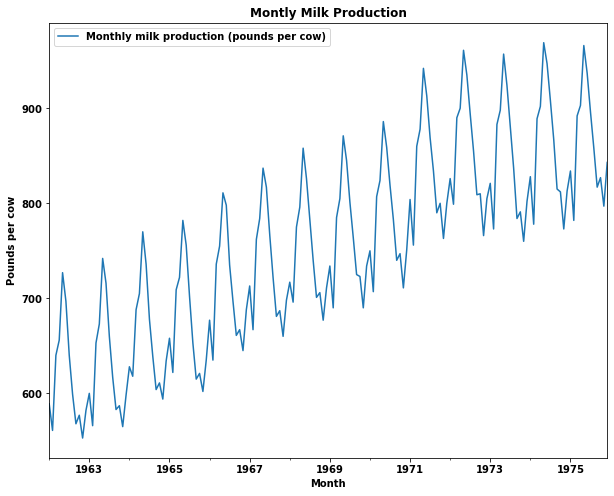

In [4]:
# Visualize the data
milk_data.plot()
plt.title("Montly Milk Production")
plt.ylabel("Pounds per cow")

As you can notice, the data have shown that it has increased in trend and it contains seasonality.

### <a name="DataSplitting">1.3 - Data Splitting
Split the data into train and test data using `train_test_split`

In [5]:
# Data Splitting
split_ratio = 0.7
train_data, test_data = train_test_split(milk_data, train_size=split_ratio , shuffle = False)
train_time,test_time = train_data.index, test_data.index

Before we build the model, we must analyze the time series data pattern. There are two ways to visualize the data seasonality:
1. ACF plot
2. Time Series Decomposition

### <a name="ACFPlot"> 1.4 - ACF Plot

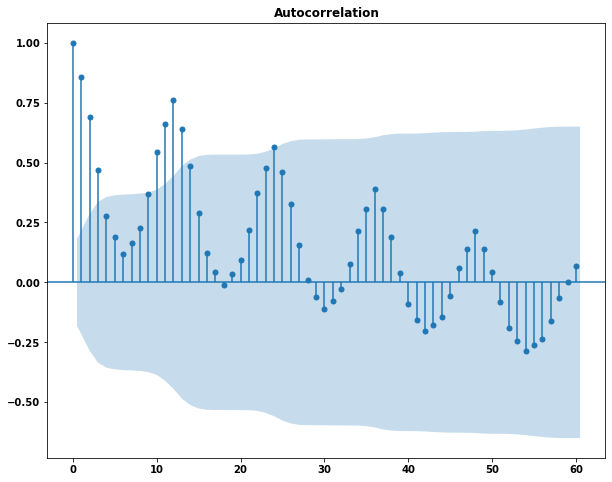

In [6]:
# Create ACF Plot
plot_acf(train_data,lags = 60)
plt.show()

### <a name="TimeSeriesDecomposition">1.5 - Time Series Decomposition
Decomposition gives us more details about the time series data pattern by decomposing the data into trend, seasonality, and residual.
>**Instruction:**<br>
Choose the correct decomposition parameters and perform time series decomposition to the `train_data`. Save the output with a variable name `decomposition`.

>**Expected Result:**<br>
![image](https://user-images.githubusercontent.com/59526258/117621580-52647400-b1a4-11eb-9590-96ed7fc97198.png)

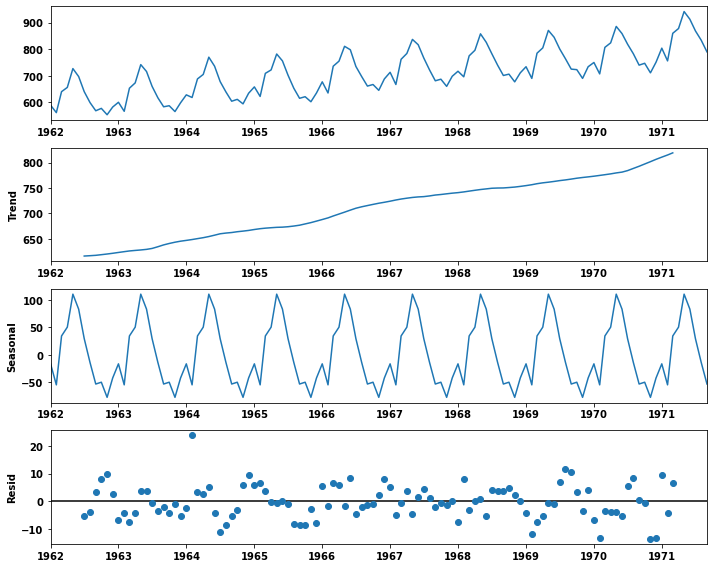

In [7]:
# Time Series Decomposition
### BEGIN SOLUTION
decomposition = seasonal_decompose(train_data, model='additive')
### END SOLUTION
decomposition.plot()
plt.show()

## <a name="TimeSeriesModelingwithStatisticalMethod">2. Time Series Modeling with Statistical Method
### <a name="NaiveForecast">2.1 - Naive Forecast
First, we will use the naive forecast method as our benchmark model. We only accept those model that is out performing than the naive forecast model based on the result.


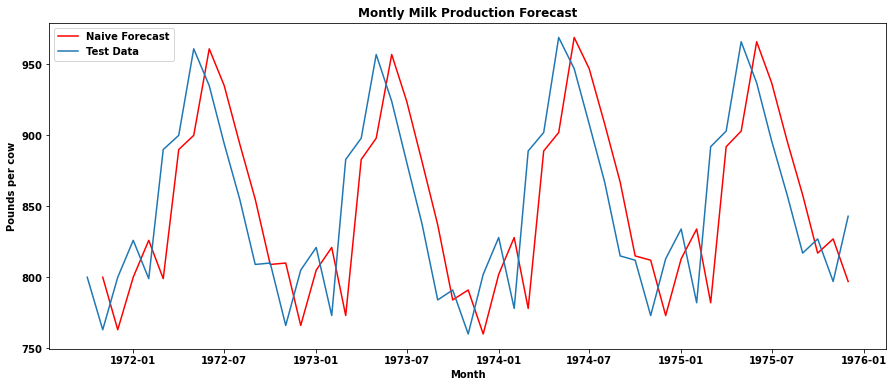

In [8]:
# Naive forecast method 
naive_forecast = test_data.shift(1)

# Function to plot the forecast data
def forecast_plot(forecast_data,forecast_label, test_label='Test Data',test_time = test_time,test_data= test_data):
    plt.figure(figsize=(15,6))
    plt.plot(test_time,forecast_data,'r',label = forecast_label,)
    plt.plot(test_time,test_data,label = test_label)
    plt.legend()
    plt.title("Montly Milk Production Forecast")
    plt.xlabel("Month")
    plt.ylabel("Pounds per cow")
    
# Plot the forecast data
forecast_plot(forecast_data = naive_forecast,forecast_label = 'Naive Forecast')    

In [9]:
# Calculate RMSE of naive model
testScore_naive = math.sqrt(mean_squared_error(test_data[1:], naive_forecast[1:]))
testScore_naive

47.39050537818731

In [10]:
# Save the result into Dataframe
result = pd.DataFrame({'Naive Forecast' :testScore_naive},index=["RMSE"])
result

,Naive Forecast
RMSE,47.390505


### <a name="ExponentialMovingAverage">2.2 - Exponential Moving Average 
#### <a name="SimpleExponentialMovingAverage(SEMA)">2.2.1 - Simple Exponential Moving Average (SEMA)
Let's start with the Simple Exponential Moving Average (SEMA) to determine whether this method is the correct method to use as our forecasting model.
>**Instruction:**<br>
Use `SimpleExpSmoothing` as the forecast model and fit it with `train_data`. Your forecast data must be same length as the test_data. Save the return with a variable name with `sema_forecast`

>**Expected Result:**<br>
![image](https://user-images.githubusercontent.com/59526258/117624498-8f7e3580-b1a7-11eb-8f46-781b87644a0e.png)


In [11]:
# Simple Exponential Moving Average (SEMA)
### BEGIN SOLUTION
sema = SimpleExpSmoothing(train_data).fit()
sema_forecast = sema.forecast(len(test_data))
### END SOLUTION
sema_forecast.head()

1971-10-01    790.220881
1971-11-01    790.220881
1971-12-01    790.220881
1972-01-01    790.220881
1972-02-01    790.220881
Freq: MS, dtype: float64

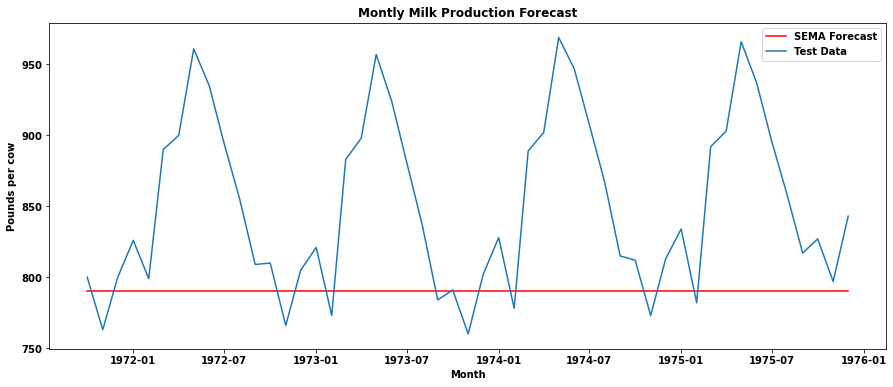

In [12]:
# Forecast data plot
forecast_plot(forecast_data = sema_forecast,forecast_label = 'SEMA Forecast' )    

In [13]:
# # Save the result into Dataframe
sema_forecast_result = math.sqrt(mean_squared_error(sema_forecast,test_data))
result['SEMA'] =  sema_forecast_result 
result

,Naive Forecast,SEMA
RMSE,47.390505,85.160721


It seems like Simple Exponential Moving Average is not a good model for the data with seasonality. Let's try the Holt-Winters Method because the model is designed to handle the time series data with seasonality.

#### <a name="Holt-WintersMethod">2.2.2 - Holt-Winters Exponential Moving Average Method
>**Instruction:**<br>
Perform both additive and multiplicative Holt-Winters Method with the `train_data` and save the model result into `result`. The number of forecast data must be the same size as the `test_data`. 

>*Hints: You may use For Loop to assist you with the iterate of parameters such as trend and seasonal.* <br>
Example:<br>
method = ['add','mul']<br>
&ensp; for trend in method:<br>
&ensp;&ensp;     for seasonal in method:<br>
&ensp;&ensp;&ensp;    ----<br>
&ensp;&ensp;&ensp;    ----<br>
&ensp;&ensp;&ensp;    ----<br>

>**Expected Result:**<br>

---|Naive Forecast|	SEMA|	add_add_forecast|	add_mul_forecast|	mul_add_forecast|	mul_mul_forecast
---|---|	---|	---|	---|	---|	---
RMSE|	47.390505|	85.317285|	51.227547|	43.414228|	65.745351|	56.389882


In [14]:
# Define Holt-Winters Exponential Moving Average model
### BEGIN SOLUTION
method = ['add','mul']
for trend in method:
    for seasonal in method:
        exponential = ExponentialSmoothing(train_data, seasonal_periods=12, trend = trend, seasonal= seasonal).fit()
        exponential_forecast = exponential.forecast(len(test_data))
        result[trend+'_'+seasonal+'_'+'forecast'] = math.sqrt(mean_squared_error(test_data, exponential_forecast))
### END SOLUTION        
result

,Naive Forecast,SEMA,add_add_forecast,add_mul_forecast,mul_add_forecast,mul_mul_forecast
RMSE,47.390505,85.160721,51.227547,43.414228,65.745351,56.389882


The result shows that Holt-Winters Method with the additive trend and multiplicative seasonal parameter is the best. Let's visualize the forecast data.

In [15]:
# Use additive trend and multiplicative seasonal Holt-Winters method to forecast
exponential = ExponentialSmoothing(train_data, seasonal_periods=12, trend='add', seasonal='mul').fit()
exponential_forecast = exponential.forecast(len(test_data))

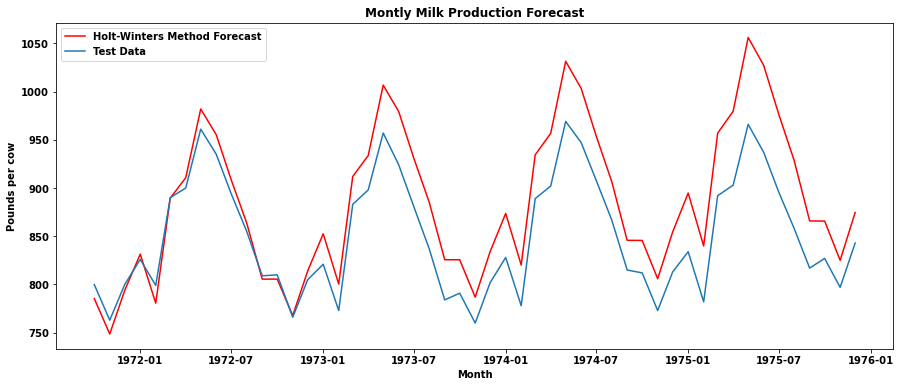

In [16]:
# Exponential forecast plot
forecast_plot(forecast_data = exponential_forecast,forecast_label = 'Holt-Winters Method Forecast')  

### <a name="ARIMAForecast">2.3 - ARIMA Forecast

#### <a name="LogTransform">2.3.1 - Log Transform

Text(0, 0.5, 'Pounds per cow')

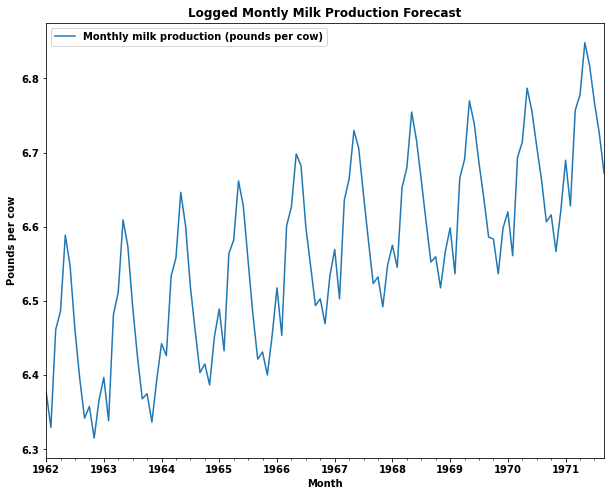

In [17]:
# Log Transform 
train_data_log = np.log(train_data)
train_data_log.plot()
plt.title("Logged Montly Milk Production Forecast")
plt.ylabel("Pounds per cow")

#### <a name="SeasonalDifferencing(Deseasonalize)">2.3.2 -  Seasonal Differencing (Deseasonalize)
`ARIMA` is only good at handling the data without seasonality. Let's remove the data seasonality by using the differencing technique with a `differencing_month = 12`. The `differencing_month` is determined base on the seasonality period of the data.

**How seasonal differencing work?**<br>
The table below shown the calculation process of seasonal differencing (seasonal period=2). 
> The seasonal period can be any values base on the nature of the time series data seasonal period.

After shifting the data down to two columns (due to seasonal period=2), perform subtraction to the `Data` and the shifted data (`Shift(2)`). Your final result will be the data that has been remove seasonality.
![concept](../../picture/seasonal_difference.png)


Text(0, 0.5, 'Pounds per cow')

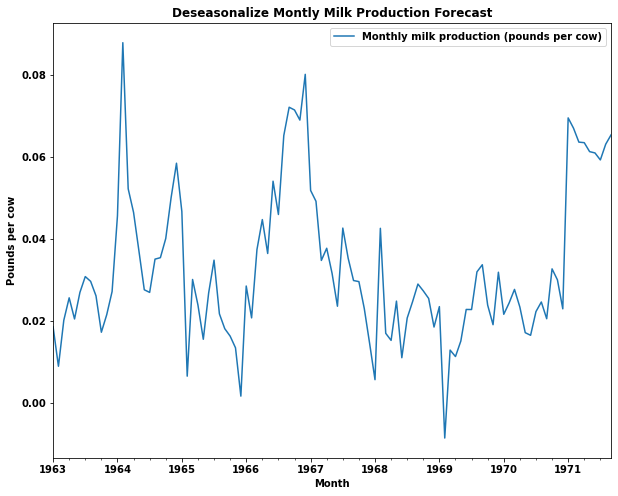

In [18]:
# Seasonal Differencing
differencing_month = 12 
remove_seasonal = train_data_log.diff(differencing_month)
deseasonal_data = remove_seasonal[differencing_month:]
deseasonal_data.plot()
plt.title("Deseasonalize Montly Milk Production Forecast")
plt.ylabel("Pounds per cow")

After removing the seasonality, it is essential to perform an `ADF` test to check whether the data is achieved through stationary data. The data after seasonal differencing still have the trend properties, which will make the data non-stationary.

#### <a name="ADFTest"> 2.3.3 - ADF Test

In [19]:
# ADF Test
def print_adf_result(adf_result):
    df_results = pd.Series(adf_result[0:4], index=['ADF Test Statistic','P-Value','# Lags Used','# Observations Used'])
    
    for key, value in adf_result[4].items():
        df_results['Critical Value (%s)'% key] = value
    print('Augmented Dickey-Fuller Test Results:')
    print(df_results)
    

adf_result = adfuller(deseasonal_data, maxlag=12)
print_adf_result(adf_result)

Augmented Dickey-Fuller Test Results:
ADF Test Statistic      -2.519930
P-Value                  0.110700
# Lags Used             12.000000
# Observations Used     92.000000
Critical Value (1%)     -3.503515
Critical Value (5%)     -2.893508
Critical Value (10%)    -2.583824
dtype: float64


It seems that the data is not stationary yet. You are required to perform 1st order differencing to make the data stationary.

####  <a name="1storderdifferencing(Detrending)">2.3.4 - 1st order differencing (Detrending)
**How 1st order differencing work?**<br>
The concept is similar to seasonal differencing. The only difference is 1st order differencing will always perform subtraction to the shifted data with period=1.<br>
For Example:<br>
![detrending_concept](../../picture/TS_detrending_concept.png)
>**Instruction:**<br>
Use `df.diff()` to perform differencing to remove the trend. Save the return with variable name `detrend_data`

>**Expected Result:**<br>
![image](https://user-images.githubusercontent.com/59526258/117633502-ae34fa00-b1b0-11eb-8ec4-0e3788335210.png)

Text(0, 0.5, 'Pounds per cow')

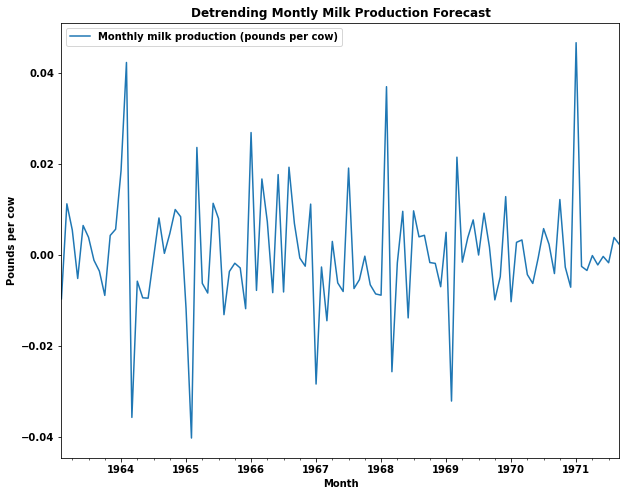

In [20]:
# 1st order differencing (Detrending
### BEGIN SOLUTION
remove_trend = deseasonal_data.diff(1)

#Skip the NaN row
detrend_data = remove_trend[1:]

### END SOLUTION
detrend_data.plot()
plt.title("Detrending Montly Milk Production Forecast")
plt.ylabel("Pounds per cow")

In [21]:
# ADF Test
result_adf = adfuller(detrend_data, maxlag=12)
print_adf_result(result_adf)

Augmented Dickey-Fuller Test Results:
ADF Test Statistic      -4.279780
P-Value                  0.000481
# Lags Used             12.000000
# Observations Used     91.000000
Critical Value (1%)     -3.504343
Critical Value (5%)     -2.893866
Critical Value (10%)    -2.584015
dtype: float64


The ADF test show that the data is in stationary now.

#### <a name="ACFandPACFplot">2.3.5 -  ACF and PACF plot
After the data is stationary, use `ACF` and `PACF` to find the `p` and `q` parameters for ARIMA model.<br>
Remind that:  <br>
`p` is determined by `PACF`<br>
`q` is determined by `ACF`<br>
>**Instruction:**<br>
Plot ACF and PACF to find the `p` and `q` parameters for ARIMA model.

>**Expected Result:**<br>
![image](https://user-images.githubusercontent.com/59526258/117634502-8c884280-b1b1-11eb-91c5-d79d91e5f983.png)

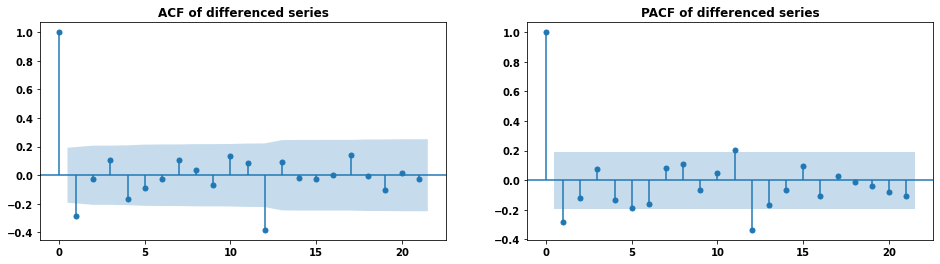

In [22]:
# ACF and PACF plot
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16, 4))
### BEGIN SOLUTION
plot_acf(detrend_data, ax1)
plot_pacf(detrend_data, ax2)
### END SOLUTION
ax1.set_title('ACF of differenced series')
ax2.set_title('PACF of differenced series')
plt.show()

#### <a name="ARIMAmodelconfiguration">2.3.6 - ARIMA model configuration

In [23]:
#  Define ARIMA model
arima = ARIMA(detrend_data.dropna(), order=(5,1,1)).fit()
arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                         ARIMA Model Results                                          
======================================================================================================
Dep. Variable:     D.Monthly milk production (pounds per cow)   No. Observations:                  103
Model:                                         ARIMA(5, 1, 1)   Log Likelihood                 303.567
Method:                                               css-mle   S.D. of innovations              0.012
Date:                                        Mon, 17 May 2021   AIC                           -591.135
Time:                                                09:34:13   BIC                           -570.057
Sample:                                            03-01-1963   HQIC                          -582.597
                                                 - 09-01-1971                                         
====================================================================================================================
                                                       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------
const                                              9.53e-06   2.44e-05      0.391      0.696   -3.83e-05    5.73e-05
ar.L1.D.Monthly milk production (pounds per cow)    -0.3139      0.097     -3.241      0.001      -0.504      -0.124
ar.L2.D.Monthly milk production (pounds per cow)    -0.0934      0.101     -0.929      0.353      -0.291       0.104
ar.L3.D.Monthly milk production (pounds per cow)     0.0304      0.101      0.302      0.763      -0.167       0.228
ar.L4.D.Monthly milk production (pounds per cow)    -0.1647      0.100     -1.655      0.098      -0.360       0.030
ar.L5.D.Monthly milk production (pounds per cow)    -0.1647      0.096     -1.722      0.085      -0.352       0.023
ma.L1.D.Monthly milk production (pounds per cow)    -0.9995      0.032    -30.796      0.000      -1.063      -0.936
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0314           -0.9579j            1.4076           -0.1191
AR.2            1.0314           +0.9579j            1.4076            0.1191
AR.3           -0.6932           -1.1608j            1.3521           -0.3357
AR.4           -0.6932           +1.1608j            1.3521            0.3357
AR.5           -1.6761           -0.0000j            1.6761           -0.5000
MA.1            1.0005           +0.0000j            1.0005            0.0000
-----------------------------------------------------------------------------
"""

#### <a name="ARIMAmodelforecast">2.3.6 - ARIMA model forecast

In [24]:
#  ARIMA model forecast
def arima_forecast(test_data):
    arima_forecast,_,_ = arima.forecast(len(test_data))
    arima_forecast = pd.Series(arima_forecast, index=test_data.index)
    return arima_forecast 
arima_forecast = arima_forecast(test_data)
arima_forecast = pd.Series(arima_forecast)
arima_forecast

Month
1971-10-01    0.000888
1971-11-01    0.001577
1971-12-01    0.000774
1972-01-01    0.000278
1972-02-01    0.001033
1972-03-01    0.000950
1972-04-01    0.000926
1972-05-01    0.001194
1972-06-01    0.001083
1972-07-01    0.000998
1972-08-01    0.001077
1972-09-01    0.001033
1972-10-01    0.001027
1972-11-01    0.001084
1972-12-01    0.001083
1973-01-01    0.001088
1973-02-01    0.001113
1973-03-01    0.001112
1973-04-01    0.001117
1973-05-01    0.001132
1973-06-01    0.001138
1973-07-01    0.001147
1973-08-01    0.001160
1973-09-01    0.001168
1973-10-01    0.001178
1973-11-01    0.001188
1973-12-01    0.001197
1974-01-01    0.001206
1974-02-01    0.001216
1974-03-01    0.001225
1974-04-01    0.001235
1974-05-01    0.001245
1974-06-01    0.001254
1974-07-01    0.001264
1974-08-01    0.001273
1974-09-01    0.001283
1974-10-01    0.001292
1974-11-01    0.001302
1974-12-01    0.001311
1975-01-01    0.001321
1975-02-01    0.001330
1975-03-01    0.001340
1975-04-01    0.001349
1975-

#### <a name="ReverseDifferencing">2.3.7 - Reverse Differencing
After getting the forecast data, you must reverse the differencing data because the forecast data is not on a correct scale.

**Data Differencing Roadmap:**<br>
Log Data -> Seasonal Differencing -> 1st Order Differencing 

**Reverse Differencing Roadmap:**<br>
Reverse 1st Order Differencing -> Reverse Seasonal Differencing -> Inverse Log Data

##### <a name="Reverse1storderdifferencing">2.3.7.1 - Reverse 1st order differencing

**Strategy to perform reverse 1st order differencing in time series data**<br>
1. Stack the forecast data and `detrend_data` together and save it as `series_merge`
2. Copy the first row of `deseasonal_data` and stack with the `series_merge`
3. Perform cumulative sum over the `series_merge`

**How to perform reverse 1st order differencing.**<br>
Instead of subtraction, the reverse of 1st order differencing using addition. The cache columns are the places to temporary store the previous answer after performing the addition between the previous data and previous cache, as shown below figure:: 
![detrending_concept](../../picture/reverse_differencing.png)

> `Cache` can be an empty list that able to store and append the latest answer 

In Python, there is an optional way to do this operation using `df.cumsum()`, which means perform a cumulative sum towards the data.
For example:<br>
![detrending_concept](../../picture/cumulative_sum.png)

**How to perform reverse 1st order differencing after getting the forecast data**<br>
First, you are required to stack the forecast data then perform the cumulative sum over the list.<br>
For example:<br>
![detrending_concept_forecast](../../picture/reverse_differencing_forecast.png)

In [95]:
# Stack the forecast data and detrend_data together and save it as series_merge
series_merge = np.hstack([detrend_data['Monthly milk production (pounds per cow)'].values,arima_forecast])

# Copy the first row of deseasonal_data and stack with the series_merge
original_data = deseasonal_data.values[0]

# Perform cumulative sum over the series_merge
trend = np.hstack([original_data,series_merge]).cumsum()

Perform sanity check to make sure the `Deseasonal Data` is identical with the `trend` data except for the forecast data 

Text(0, 0.5, 'Pounds per cow')

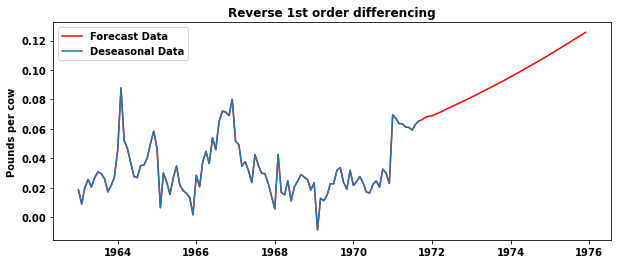

In [96]:
plt.figure(figsize=(10,4))
plt.plot(milk_data.index[12:],trend,'r',label='Forecast Data')
plt.title("Reverse 1st order differencing")
plt.plot(deseasonal_data,label='Deseasonal Data')
plt.legend()
plt.ylabel("Pounds per cow")

##### <a name="Reverseseasonaldifferencing">2.3.7.2 - Reverse seasonal differencing
**Strategy to perform reverse seasonal differencing in time series data**<br>
1. Stack the first 12 of original data(data that before remove the seasonality) and `trend` data undergoing reverse 1st order differencing together. 
2. Iterate and perform summation until the end of the list.

**How to perform reverse seasonal differencing?**<br>
The concept is almost similar with the reverse 1st order differencing. The only difference is that you need to create an empty list to store the `cache`.<br> 
For example, below table shown the calculation process of reverse seasonal differencing with seasonal period=2.<br>
![detrending_concept_forecast](../../picture/Deseasonal_Concept.png)
    
In Python, you can utilize the list `append()` method to store the original data and the result after performing addition with `cache`.
![detrending_concept_forecast](../../picture/python_reverse_seasonality.png)

In [81]:
# Create the `cache`
inverse_seasonal = np.vstack([np.zeros((differencing_month,1)),trend.reshape(-1,1)])

In [91]:
# Store the first 12 orignal data to list
seasonal_data = train_data_log.values[:differencing_month].tolist()

# Iterate and perform summation until the end of the list
for i in range(differencing_month,len(trend)+differencing_month):
    seasonal_data.append(seasonal_data[i-differencing_month] + inverse_seasonal[i])

Perform sanity check to make sure the `train_data_log` is same with the `seasonal_data` data except for the forecast part

Text(0, 0.5, 'Pounds per cow')

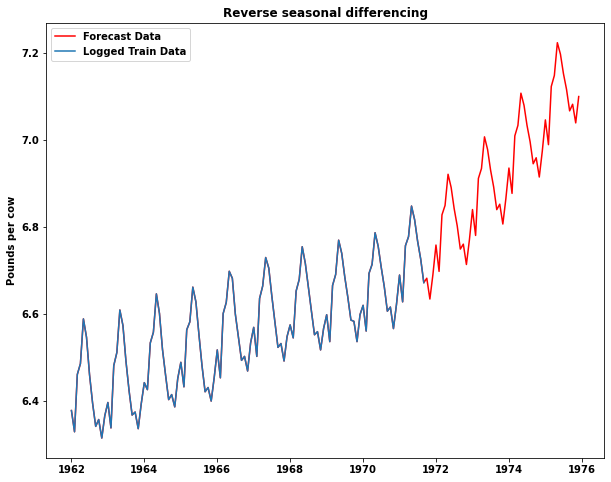

In [87]:
#  Plot the Reverse seasonal differencing for sanity check
plt.plot(milk_data.index,seasonal_data,'r',label='Forecast Data')
plt.plot(train_data_log,label='Logged Train Data')
plt.title("Reverse seasonal differencing")
plt.legend()
plt.ylabel("Pounds per cow")

The `train_data_log` is the same as the `seasonal_data` data except for the forecast part. It means that the reverse transform for 1st order differencing and seasonality differencing is correct. Do take note the data is still on the log scale, you are required to transform it back to the original scale.

#### <a name="InverseLogTransform">2.3.8 - Inverse Log Transform
>**Instruction:**<br>
Use `np.exp` to perform exponential to logged value (`seasonal_data`) to transform the data back to original values.

>**Expected Result:**<br>
array([[589.],<br>
       [561.],<br>
       [640.],<br>
       [656.],<br>
       [727.]])

In [88]:
# Inverse Log Transform
### BEGIN SOLUTION
inverse_log = np.exp(seasonal_data) 
### END SOLUTION
inverse_log[:5]

array([[589.],
       [561.],
       [640.],
       [656.],
       [727.]])

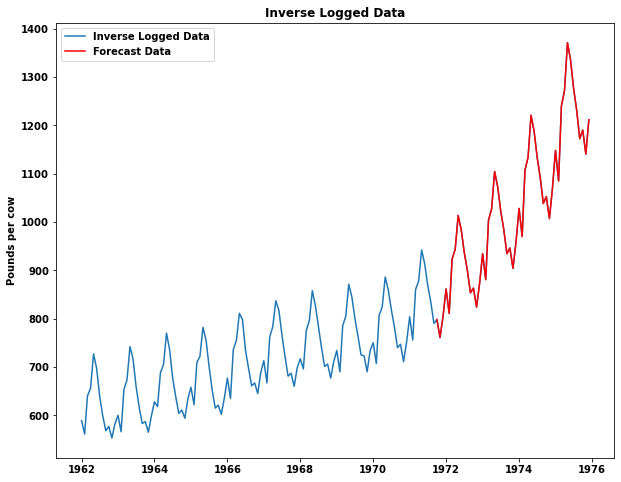

In [94]:
# Plot the Inverse log data
plt.plot(milk_data.index,inverse_log,label ='Inverse Logged Data')
plt.plot(milk_data.index[-len(test_data):],inverse_log[-len(test_data):],'r',label='Forecast Data')
plt.title("Inverse Logged Data")
plt.ylabel("Pounds per cow")
plt.legend()

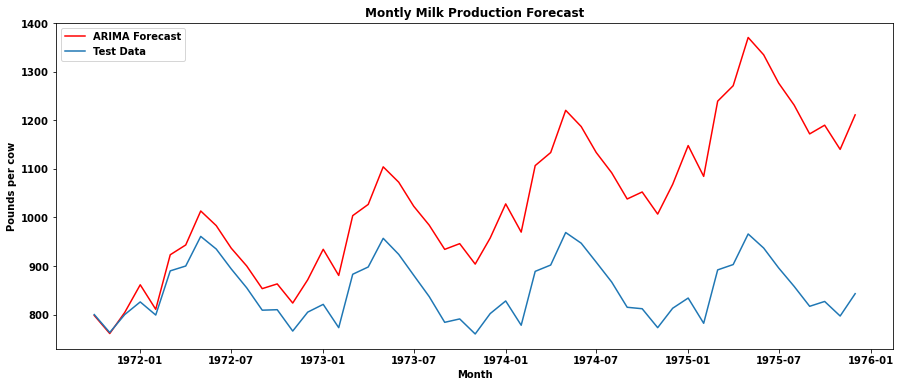

In [90]:
# Plot the Forecast Result
arima_prediction = inverse_log[-len(test_data):]
forecast_plot(forecast_data = arima_prediction,forecast_label = 'ARIMA Forecast')  

In [33]:
# Save the result into Dataframe
arima_forecast_result = math.sqrt(mean_squared_error(arima_prediction,test_data))
result['ARIMA Forecast'] =  arima_forecast_result
result

,Naive Forecast,SEMA,add_add_forecast,add_mul_forecast,mul_add_forecast,mul_mul_forecast,ARIMA Forecast
RMSE,47.390505,85.160721,51.227547,43.414228,65.745351,56.389882,219.266373


### <a name="SARIMAForecast">2.4 - SARIMA Forecast
>**Instruction:**<br>
Use `pm.arima.auto_arima()` to perform the prediction by using SARIMA model with seasonal period, `m=12`

>**Expected Result:**<br>
Fit ARIMA: order=(2, 0, 2) seasonal_order=(1, 1, 1, 12); AIC=734.227, BIC=755.458, Fit time=0.754 seconds<br>
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 1, 0, 12); AIC=848.245, BIC=853.553, Fit time=0.009 seconds<br>
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 1, 0, 12); AIC=741.855, BIC=752.471, Fit time=0.154 seconds<br>
.<br>
.<br>
.<br>
Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 1, 1, 12); AIC=733.075, BIC=743.691, Fit time=0.120 seconds<br>

In [34]:
import six
import sys
sys.modules['sklearn.externals.six'] = six
import joblib
sys.modules['sklearn.externals.joblib'] = joblib
import pmdarima as pm

### BEGIN SOLUTION
auto_arima = pm.arima.auto_arima(train_data, m=12,
                            trace=True, seasonal=True,
                            error_action='ignore',  
                            suppress_warnings=True)
### END SOLUTION

Fit ARIMA: order=(2, 0, 2) seasonal_order=(1, 1, 1, 12); AIC=734.227, BIC=755.458, Fit time=0.754 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 1, 0, 12); AIC=848.245, BIC=853.553, Fit time=0.009 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 1, 0, 12); AIC=741.855, BIC=752.471, Fit time=0.154 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 1, 1, 12); AIC=771.446, BIC=782.062, Fit time=0.114 seconds
Fit ARIMA: order=(2, 0, 2) seasonal_order=(0, 1, 1, 12); AIC=730.692, BIC=749.270, Fit time=0.328 seconds
Fit ARIMA: order=(2, 0, 2) seasonal_order=(0, 1, 0, 12); AIC=752.625, BIC=768.549, Fit time=0.127 seconds
Fit ARIMA: order=(2, 0, 2) seasonal_order=(0, 1, 2, 12); AIC=732.617, BIC=753.849, Fit time=0.814 seconds
Fit ARIMA: order=(2, 0, 2) seasonal_order=(1, 1, 2, 12); AIC=734.260, BIC=758.145, Fit time=1.040 seconds
Fit ARIMA: order=(1, 0, 2) seasonal_order=(0, 1, 1, 12); AIC=729.622, BIC=745.545, Fit time=0.236 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 

In [35]:
# SARIMA Summary
auto_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  117
Model:             SARIMAX(1, 0, 1)x(0, 1, 1, 12)   Log Likelihood                -359.776
Date:                            Mon, 17 May 2021   AIC                            729.551
Time:                                    09:34:26   BIC                            742.821
Sample:                                         0   HQIC                           734.929
                                            - 117                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      2.6014      1.752      1.485      0.138      -0.832       6.035
ar.L1          0.8892      0.077     11.483      0.000       0.737       1.041
ma.L1         -0.2674      0.139     -1.919      0.055      -0.541       0.006
ma.S.L12      -0.5960      0.108     -5.513      0.000      -0.808      -0.384
sigma2        52.3238      7.026      7.447      0.000      38.552      66.095
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):                39.10
Prob(Q):                              0.84   Prob(JB):                         0.00
Heteroskedasticity (H):               1.45   Skew:                             0.95
Prob(H) (two-sided):                  0.28   Kurtosis:                         5.30
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [36]:
# SARIMA model prediction
auto_arima_forecast = auto_arima.predict(len(test_data))
auto_arima_forecast_series = pd.Series(auto_arima_forecast, index=test_data.index)

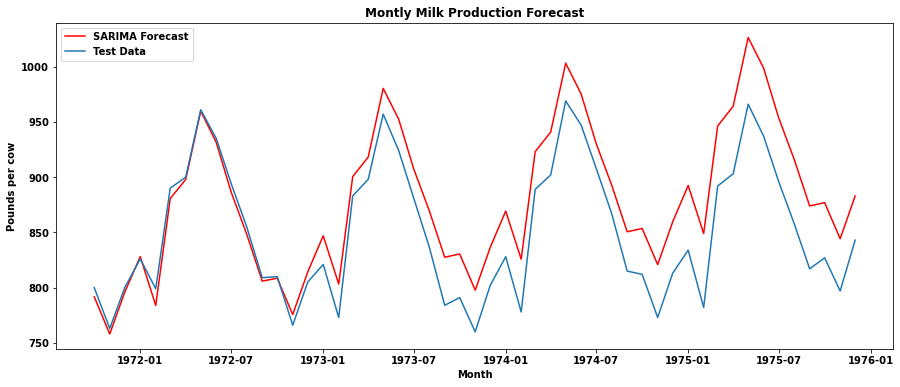

In [37]:
# Plot the forecast data
forecast_plot(forecast_data = auto_arima_forecast_series, forecast_label = 'SARIMA Forecast') 

In [38]:
# Save the result into Dataframe
sarima_result = math.sqrt(mean_squared_error(test_data,auto_arima_forecast_series))
result['SARIMA Forecast'] =  sarima_result
result

,Naive Forecast,SEMA,add_add_forecast,add_mul_forecast,mul_add_forecast,mul_mul_forecast,ARIMA Forecast,SARIMA Forecast
RMSE,47.390505,85.160721,51.227547,43.414228,65.745351,56.389882,219.266373,36.43698


# <a name="TimeSeriesModelingwithDeepLearningMethod(MLP)">3. Time Series Modeling with Deep Learning Method (MLP)

### <a name="Hyperparamter">3.1 - Hyperparamter

In [39]:
# Hyperparamter
window_size = 3
n_epoch = 500
batch_size = 5 

### <a name="DataScaling">3.2 - Data Scaling


In [40]:
# Data Scaling
scaler = StandardScaler().fit(train_data)
train_data_scale = scaler.transform(train_data)
test_data_scale = scaler.transform(test_data)

### <a name="WindowSliding">3.3 - Window Sliding 
#### Optional 1 - Use the previous sliding window function

In [41]:
# Window Sliding Function
def sliding_window(univariate_data,window_size):
    x,y = list(),list()
    for i in range(len(univariate_data)):
        end_ix = i + window_size
        if end_ix > len(univariate_data)-1:
            break
        seq_x, seq_y = univariate_data[i:end_ix], univariate_data[end_ix]
        x.append(seq_x)
        y.append(seq_y)
    return np.array(x),np.array(y)

train_feature , train_label = sliding_window(train_data_scale,window_size)
test_feature , test_label = sliding_window(test_data_scale,window_size)

#### Optional 2 - Use helper function from data_module

In [42]:
# Helper Function from previous exercise
import data_module
train_feature , train_label = data_module.univariate_single_step(train_data_scale,window_size)
test_feature , test_label = data_module.univariate_single_step(test_data_scale,window_size)

### <a name="DataIterator">3.4 - Data Iterator

####  Optional 1 - Using Pytorch Custom Dataset Method
>**Instruction:**<br>
Create Data Iterator using Pytorch Custom Dataset Method

In [66]:
class Custom_Dataset(Dataset):
    ### BEGIN SOLUTION
    def __init__(self,features,labels):
        self.features = torch.tensor(features,dtype = torch.float32)
        self.labels = torch.tensor(labels,dtype = torch.float32)
        
    def __len__(self):
        return self.features.shape[0]
    
    def __getitem__(self,idx):
        return self.features[idx],self.labels[idx]
    ### END SOLUTION

In [67]:
train_dataset = Custom_Dataset(train_feature,train_label)
test_dataset = Custom_Dataset(test_feature,test_label)
train_iterator = DataLoader(train_dataset,batch_size,shuffle = False)
test_iterator = DataLoader(test_dataset,batch_size,shuffle = False)

#### Optional 2 - TensorDataset
>**Instruction:**<br>
Create Data Iterator using `TensorDataset`

In [45]:
trainX = torch.from_numpy(train_feature).type(torch.Tensor)
trainY = torch.from_numpy(train_label).type(torch.Tensor)
testX = torch.from_numpy(test_feature).type(torch.Tensor)
testY = torch.from_numpy(test_label).type(torch.Tensor)

### BEGIN SOLUTION
train_dataset = TensorDataset(trainX,trainY)
test_dataset = TensorDataset(testX,testY)
### END SOLUTION

train_iterator = DataLoader(train_dataset,batch_size,shuffle = False)
test_iterator = DataLoader(test_dataset,batch_size,shuffle = False)

### <a name="Multilayerperceptron(MLP)configuration">3.5 - Multilayer perceptron (MLP) configuration
>**Instruction:**<br>
Create the MLP configuration based on the **Expected Result:**<br>

>**Expected Result:**<br>
![image](https://user-images.githubusercontent.com/59526258/118422293-83d5c600-b6f5-11eb-842e-300b63950228.png)


In [46]:
class MLP(nn.Module):
    def __init__(self,input_size,output_size):
        super(MLP,self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.input_layer = nn.Linear(input_size,10)
        self.hidden_layer = nn.Linear(10,5)
        self.output_layer = nn.Linear(5,output_size)
        
    def forward(self,x):
        x = x.view(-1,input_size)
        out = F.relu(self.input_layer(x))
        out = F.relu(self.hidden_layer(out))
        out = self.output_layer(out)
        return out

### <a name="InputModel">3.6 - Input Model

In [47]:
torch.manual_seed(123)
input_size = window_size
output_size = 1
model = MLP(input_size, output_size)
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr= 0.01)

In [48]:
# Xavier weight intialization
torch.manual_seed(123)
def weights_init(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight.data)

        
model.apply(weights_init)

MLP(
  (input_layer): Linear(in_features=3, out_features=10, bias=True)
  (hidden_layer): Linear(in_features=10, out_features=5, bias=True)
  (output_layer): Linear(in_features=5, out_features=1, bias=True)
)

### <a name="ModelSummary">3.7 - Model Summary

In [49]:
%%capture
# pip install this package to view the summary of model  
# used pip install due to it does not have conda version
# %%capture suppress information of torchsummaryX installation
!pip install torchsummaryX
from torchsummaryX import summary

In [50]:
inputs = torch.zeros((batch_size,window_size),dtype=torch.float) # batch size,seq_dimension
print(summary(model,inputs))

               Kernel Shape Output Shape  Params  Mult-Adds
Layer                                                      
0_input_layer       [3, 10]      [5, 10]      40         30
1_hidden_layer      [10, 5]       [5, 5]      55         50
2_output_layer       [5, 1]       [5, 1]       6          5
-----------------------------------------------------------
                      Totals
Total params             101
Trainable params         101
Non-trainable params       0
Mult-Adds                 85
               Kernel Shape Output Shape  Params  Mult-Adds
Layer                                                      
0_input_layer       [3, 10]      [5, 10]      40         30
1_hidden_layer      [10, 5]       [5, 5]      55         50
2_output_layer       [5, 1]       [5, 1]       6          5


### <a name="Training">3.8 - Training

In [51]:
def training(num_epochs,train_iter,test_iter,optimizer,loss_fn,model):
    # Create a list of zero value to store the averaged value
    train_loss = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    
    ### BEGIN SOLUTION
    
    for t in range(num_epochs):
        
        # Initial the value to be zero to perform cumulative sum 
        running_loss_train = 0
        running_loss_valid = 0
        
        # For loop to loop through each data in the data iterator
        for _,(train_X,train_Y) in enumerate(train_iter):
            
            # Forward pass
            y_train_pred = model(train_X)

            # Reshape to ensure the predicted output (y_train_pred) same size with train_Y shape
            y_train_pred=torch.reshape(y_train_pred,(train_Y.shape[0],train_Y.shape[1]))
            
            # Compare the value using MSE
            loss_train = loss_fn(y_train_pred, train_Y)

            # Zero out gradient, else they will accumulate between batches
            optimizer.zero_grad()

            # Backward pass
            loss_train.backward()

            # Update parameters
            optimizer.step()
            
            # Since the loss_train.item will only return the average loss based number of batches
            # loss_train.item()*train_X.size(0) -> to make it multiply with batch size 
            running_loss_train += loss_train.item()*train_X.size(0)
            
        # Average the loss base on total batch size ,train_iter.dataset is use to get the total batch size 
        epoch_loss_train = running_loss_train /len(train_iter.dataset)
        # Store the averaged value
        train_loss[t] = epoch_loss_train
        
        # Validate the test data loss
        with torch.no_grad():
            # For loop to loop through each data in the data iterator
            for _,(test_X,test_Y) in enumerate(test_iter):
                y_test_pred = model(test_X)

                # Reshape to ensure the predicted output (y_test_pred) same size with test_y shape
                y_test_pred=torch.reshape(y_test_pred,(test_Y.shape[0],test_Y.shape[1]))
                
                # Calculate the loss 
                loss_test = loss_fn(y_test_pred, test_Y)
                
                # Summing up the loss over each batch
                running_loss_valid += loss_test.item()*test_X.size(0)
                
        # Average the loss base on total batch size 
        epoch_loss_test =running_loss_valid /len(test_iter.dataset)
        
        # Store the averaged value
        val_loss[t] = epoch_loss_test
        
    ### END SOLUTION
    return train_loss,val_loss

In [52]:
train_loss,val_loss = training(n_epoch,train_iterator,test_iterator,optimizer,loss_fn,model)

In [53]:
for i in range(n_epoch):
    print(f"Epoch: {i}, train loss: {train_loss[i]} ,test loss: {val_loss[i]}")

Epoch: 0, train loss: 1.386854114206998 ,test loss: 2.0060096085071564
Epoch: 1, train loss: 0.43878978909107674 ,test loss: 1.0301584266126156
Epoch: 2, train loss: 0.31535910945712475 ,test loss: 0.38090148428454995
Epoch: 3, train loss: 0.2895444410019799 ,test loss: 0.3451864802433799
Epoch: 4, train loss: 0.2509275770239663 ,test loss: 0.36027291836217046
Epoch: 5, train loss: 0.24611274682377515 ,test loss: 0.34498872646751505
Epoch: 6, train loss: 0.228059472712247 ,test loss: 0.37265682329113287
Epoch: 7, train loss: 0.22977409178489133 ,test loss: 0.36152165352056426
Epoch: 8, train loss: 0.2156509991343084 ,test loss: 0.36502151610329747
Epoch: 9, train loss: 0.22088915867763653 ,test loss: 0.3644891699465613
Epoch: 10, train loss: 0.20647095333327325 ,test loss: 0.35098461667075753
Epoch: 11, train loss: 0.21146921970342336 ,test loss: 0.359020434319973
Epoch: 12, train loss: 0.20024179663966624 ,test loss: 0.3436891520395875
Epoch: 13, train loss: 0.20142452908973946 ,test 

### <a name="Validation">3.9 - Validation

In [54]:
with torch.no_grad():
    train_prediction = model(trainX)
    test_prediction = model(testX)

In [55]:
# Inverse Scaling
train_label_rescale = scaler.inverse_transform(train_label)
test_label_rescale = scaler.inverse_transform(test_label)
train_prediction_rescale = scaler.inverse_transform(train_prediction)
test_prediction_rescale = scaler.inverse_transform(test_prediction)

In [56]:
print("Test Data\t\t\tForecast Data")
for i in range(len(test_label_rescale )):
    print(f"{test_label_rescale[i]}\t\t{test_prediction_rescale[i]}")

Test Data			Forecast Data
[826.]		[832.1094]
[799.]		[778.0338]
[890.]		[820.8547]
[900.]		[894.70905]
[961.]		[947.03265]
[935.]		[928.00745]
[894.]		[894.11224]
[855.]		[850.5225]
[809.]		[799.4553]
[810.]		[745.82336]
[766.]		[803.59656]
[805.]		[772.319]
[821.]		[834.4018]
[773.]		[767.8612]
[883.]		[796.2839]
[898.]		[902.61725]
[957.]		[974.1459]
[924.]		[918.7499]
[881.]		[896.19727]
[837.]		[823.73804]
[784.]		[768.17303]
[791.]		[702.54596]
[760.]		[751.467]
[802.]		[795.508]
[828.]		[832.6924]
[778.]		[771.26465]
[889.]		[814.63116]
[902.]		[909.77734]
[969.]		[975.843]
[947.]		[933.3186]
[908.]		[894.5924]
[867.]		[873.698]
[815.]		[807.7472]
[812.]		[732.5575]
[773.]		[797.62195]
[813.]		[785.1246]
[834.]		[848.9472]
[782.]		[778.1039]
[892.]		[802.3518]
[903.]		[914.8893]
[966.]		[972.01056]
[937.]		[931.48047]
[896.]		[898.8647]
[858.]		[847.77954]
[817.]		[804.59546]
[827.]		[765.9406]
[797.]		[848.5187]
[843.]		[823.4707]


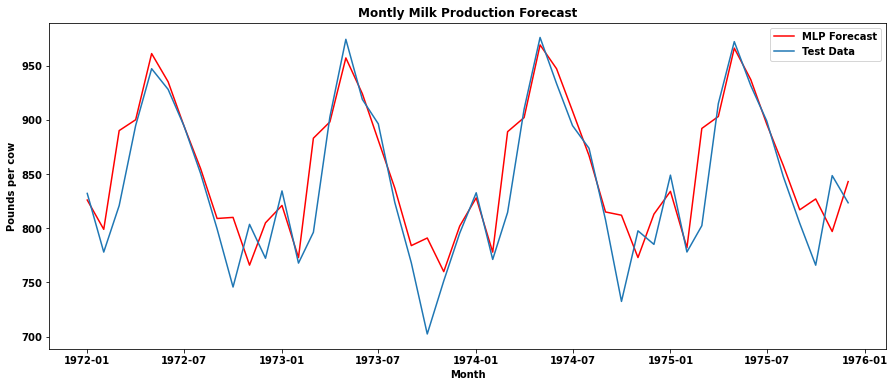

In [57]:
# Plot the Forecast Data
forecast_plot(forecast_data = test_label_rescale, 
              forecast_label = 'MLP Forecast',
              test_time=test_time[window_size:],
              test_data=test_prediction_rescale) 

In [58]:
mlp_train_result = math.sqrt(mean_squared_error(train_label_rescale,train_prediction_rescale))
mlp_forecast_result = math.sqrt(mean_squared_error(test_label_rescale,test_prediction_rescale))
print('Train Score: %.2f RMSE' % (mlp_train_result))
print('Test Score: %.2f RMSE' % (mlp_forecast_result))

Train Score: 16.14 RMSE
Test Score: 34.85 RMSE


In [59]:
result['MLP Forecast'] =  mlp_forecast_result
result

,Naive Forecast,SEMA,add_add_forecast,add_mul_forecast,mul_add_forecast,mul_mul_forecast,ARIMA Forecast,SARIMA Forecast,MLP Forecast
RMSE,47.390505,85.160721,51.227547,43.414228,65.745351,56.389882,219.266373,36.43698,34.846151


In conclusion, MLP model gives the lowest RMSE which is appropriate to make it as our forecast model for future unseen data. The second option goes to SARIMA model which the MSE just slightly higher than the MLP model but way to compute faster.

## <a name="Summary">Summary
From this tutorial, you should have learned:

1. Understand the time series forecasting flow.
2. Compare and select the optimal model as forecasting model base on the model performance. 

This tutorial only covers MLP in the Deep Learning section. You may include the LSTM and CNN deep learning model on your own and observe the performance between them.<br>
    
Congratulations, that concludes this lesson.

## <a name="Reference">Reference
1. [Deep Learning for Time Series Forecasting (Predict the Future with MLPs,CNNs and LSTMs in Python) , Jason Brownlee](https://machinelearningmastery.com/deep-learning-for-time-series-forecasting/)
2. [Time-series Forecasting Flow](https://towardsdatascience.com/time-series-forecasting-flow-2e49740664de)